In [ ]:
!pip install pylibdmtx albumentations opencv-python matplotlib Pillow



Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# %%
import os
import random
from pathlib import Path

import cv2
import numpy as np
from pylibdmtx.pylibdmtx import encode

import albumentations as A
import matplotlib.pyplot as plt

# ---------------------
# CONFIG À ADAPTER
# ---------------------

# Dossier qui contient tes backgrounds PCB
BACKGROUND_DIR = Path("/home/benoiserie/Bureau/Thesis/images")

# Dossiers de sortie
OUTPUT_IMAGES_DIR = Path("../synthetic_dm/images")
OUTPUT_LABELS_DIR = Path("../synthetic_dm/labels")

# Nombre d'images synthétiques à générer par background (pour le test)
SYNTH_PER_BACKGROUND = 1  # tu pourras augmenter après test

# Nombre de DataMatrix par image (min et max)
MIN_DM_PER_IMAGE = 1
MAX_DM_PER_IMAGE = 4

# Crée les dossiers de sortie si besoin
OUTPUT_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_LABELS_DIR.mkdir(parents=True, exist_ok=True)

# Pour avoir des résultats reproductibles
random.seed(42)
np.random.seed(42)

print(f"Backgrounds: {BACKGROUND_DIR}")
print(f"Sortie images: {OUTPUT_IMAGES_DIR}")
print(f"Sortie labels: {OUTPUT_LABELS_DIR}")


Backgrounds: /home/benoiserie/Bureau/Thesis/backgrounds/train/images
Sortie images: ../synthetic_dm/images
Sortie labels: ../synthetic_dm/labels


Shape DM: (90, 90)


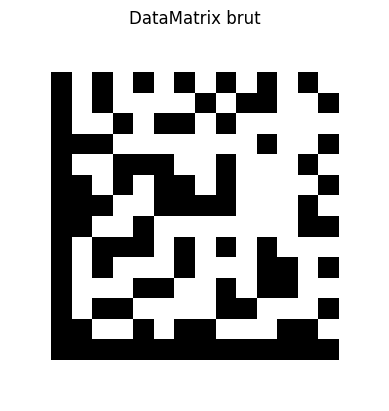

In [ ]:
from pylibdmtx.pylibdmtx import encode
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_datamatrix(text: str = "TEST") -> np.ndarray:
    """
    Génère une image DataMatrix (PNG-like) en niveaux de gris.
    Retourne un np.ndarray compatible OpenCV.
    """
    # encode attend des bytes → on encode en UTF-8
    encoded = encode(text.encode("utf-8"))

    # Construction d'une image PIL à partir des pixels bruts
    img_pil = Image.frombytes(
        "RGB",
        (encoded.width, encoded.height),
        encoded.pixels
    )

    # Conversion en niveaux de gris pour notre pipeline
    dm = np.array(img_pil.convert("L"))
    return dm

# Test rapide d'une génération
dm_test = generate_datamatrix("DM_TEST")
print("Shape DM:", dm_test.shape)

plt.imshow(dm_test, cmap="gray")
plt.title("DataMatrix brut")
plt.axis("off")
plt.show()


In [ ]:
dm_augmentations = A.Compose([
    A.GaussianBlur(p=0.3),
    A.MotionBlur(p=0.2),
    A.RandomBrightnessContrast(p=0.5),
    A.ImageCompression(quality_lower=60, quality_upper=95, p=0.5),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.4),
    A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.Perspective(scale=(0.03, 0.10), keep_size=True, pad_mode=cv2.BORDER_CONSTANT, p=0.5),
])

def augment_datamatrix(dm: np.ndarray) -> np.ndarray:
    """
    Applique des augmentations réalistes sur l'image DataMatrix.
    dm: image en niveaux de gris ou BGR.
    Retourne une image BGR.
    """
    # Si grayscale → BGR
    if len(dm.shape) == 2:
        dm_bgr = cv2.cvtColor(dm, cv2.COLOR_GRAY2BGR)
    else:
        dm_bgr = dm

    augmented = dm_augmentations(image=dm_bgr)["image"]
    return augmented

/tmp/ipykernel_195141/247387317.py:5: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=60, quality_upper=95, p=0.5),
/tmp/ipykernel_195141/247387317.py:6: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0), p=0.4),
/tmp/ipykernel_195141/247387317.py:8: UserWarning: Argument(s) 'pad_mode' are not valid for transform Perspective
  A.Perspective(scale=(0.03, 0.10), keep_size=True, pad_mode=cv2.BORDER_CONSTANT, p=0.5),


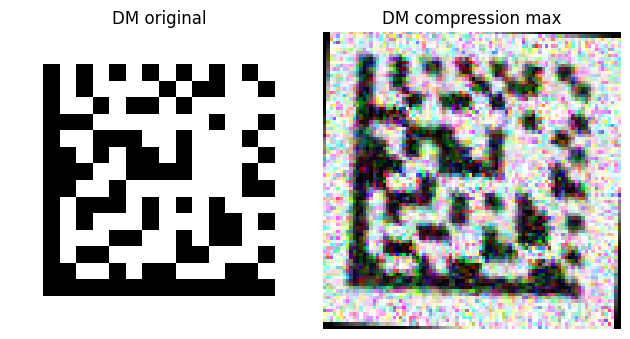

In [ ]:
# Visualisation rapide pour contrôle
aug_dm = augment_datamatrix(dm_test)

plt.subplot(1, 2, 1)
plt.title("DM original")
plt.imshow(dm_test, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("DM compression max")
plt.imshow(cv2.cvtColor(aug_dm, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# %%
def resize_dm_for_background(dm_bgr: np.ndarray, bg_h: int, bg_w: int,
                             min_rel_size: float = 0.05,
                             max_rel_size: float = 0.20) -> np.ndarray:
    """
    Redimensionne le DM pour qu'il occupe entre min_rel_size et max_rel_size
    de la plus petite dimension de l'image background.
    """
    dm_h, dm_w = dm_bgr.shape[:2]
    target_rel_size = random.uniform(min_rel_size, max_rel_size)
    target_size = int(min(bg_h, bg_w) * target_rel_size)
    # Le DM est carré → on garde la forme
    scale = target_size / max(dm_h, dm_w)
    new_w = max(4, int(dm_w * scale))
    new_h = max(4, int(dm_h * scale))
    dm_resized = cv2.resize(dm_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return dm_resized


def overlay_dm_on_background(bg_bgr: np.ndarray, dm_bgr: np.ndarray, keep_white_bg: bool = False):
    """
    - keep_white_bg=False : "sans fond" -> on applique seulement les pixels du code
      en évitant les artefacts noirs dus aux rotations/perspectives.
    - keep_white_bg=True  : "fond blanc" -> on colle le patch complet (rectangle)
    """
    bg_h, bg_w = bg_bgr.shape[:2]
    dm_h, dm_w = dm_bgr.shape[:2]

    if dm_w >= bg_w or dm_h >= bg_h:
        return bg_bgr, None

    x = random.randint(0, bg_w - dm_w)
    y = random.randint(0, bg_h - dm_h)

    roi = bg_bgr[y:y + dm_h, x:x + dm_w]
    out = bg_bgr.copy()

    if keep_white_bg:
        # --- Mode "fond blanc" : colle tout le patch ---
        out[y:y + dm_h, x:x + dm_w] = dm_bgr

    else:
        # --- Mode "sans fond" : colle uniquement le code ---
        dm_gray = cv2.cvtColor(dm_bgr, cv2.COLOR_BGR2GRAY)

        # 1) Exclure les pixels très sombres (artefacts de remplissage après rotation/perspective)
        #    Ajuste 10..30 selon ton rendu
        t_fill = 15

        # 2) Définir ce qu'on considère "code"
        #    Plus bas -> plus strict (moins de gris). Plus haut -> plus permissif.
        t_code = 240

        # Masque = pixels du code (foncés) MAIS pas les noirs extrêmes d'artefact
        mask = ((dm_gray < t_code) & (dm_gray > t_fill)).astype(np.uint8) * 255

        inv_mask = cv2.bitwise_not(mask)
        bg_part = cv2.bitwise_and(roi, roi, mask=inv_mask)
        dm_part = cv2.bitwise_and(dm_bgr, dm_bgr, mask=mask)
        blended = cv2.add(bg_part, dm_part)

        out[y:y + dm_h, x:x + dm_w] = blended

    # bbox YOLO (rectangulaire, zone du patch)
    xc = (x + dm_w / 2) / bg_w
    yc = (y + dm_h / 2) / bg_h
    w_norm = dm_w / bg_w
    h_norm = dm_h / bg_h

    return out, (xc, yc, w_norm, h_norm)



382 backgrounds trouvés
[OK] pcb_synth_00000.jpg avec 1 DataMatrix


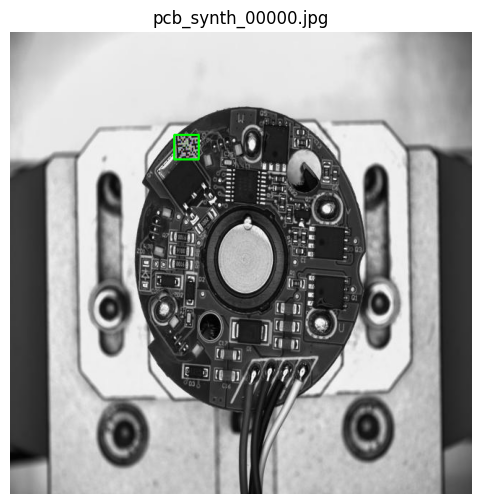

--- Annotations YOLO ---
0 0.382812 0.248438 0.053125 0.053125
------------------------

[OK] pcb_synth_00001.jpg avec 1 DataMatrix


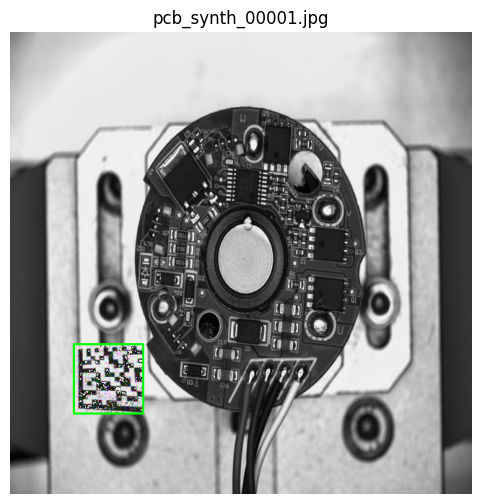

--- Annotations YOLO ---
0 0.214062 0.750000 0.150000 0.150000
------------------------

[OK] pcb_synth_00002.jpg avec 1 DataMatrix


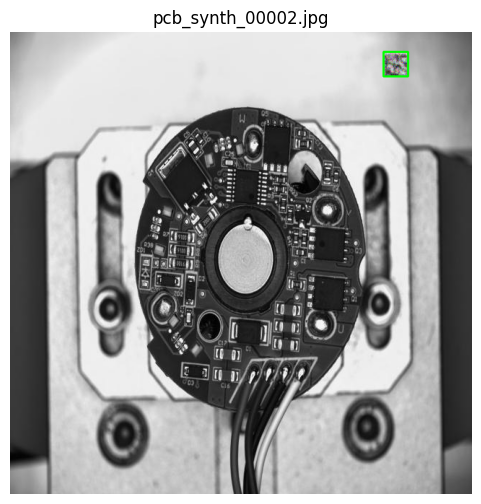

--- Annotations YOLO ---
0 0.834375 0.068750 0.053125 0.053125
------------------------



In [ ]:
# %%
# Récupération des backgrounds images
valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}
background_paths = [p for p in BACKGROUND_DIR.iterdir() if p.suffix.lower() in valid_exts]

print(f"{len(background_paths)} backgrounds trouvés")

image_counter = 0

# Pour le test, on limite par exemple à 3 backgrounds
max_backgrounds_for_test = 3

# Limiter le nombre d'images affichées dans le notebook
MAX_VISUALIZE = 5
n_visualized = 0

for bg_path in background_paths[:max_backgrounds_for_test]:
    bg = cv2.imread(str(bg_path))
    if bg is None:
        print(f"[WARN] Impossible de lire {bg_path}")
        continue

    bg_h, bg_w = bg.shape[:2]

    for i in range(SYNTH_PER_BACKGROUND):
        img_out = bg.copy()
        labels = []

        # Choisir entre 1 et 4 DM
        n_dm = random.randint(MIN_DM_PER_IMAGE, MAX_DM_PER_IMAGE)

        for k in range(n_dm):
            # 1) Génération DataMatrix
            text = f"DM_{image_counter}_{k}"
            dm = generate_datamatrix(text=text)

            # 2) Augmentations style SyntheticDomino
            dm_aug = augment_datamatrix(dm)

            # 3) Resize par rapport au background
            dm_resized = resize_dm_for_background(dm_aug, bg_h, bg_w)
            keep_white = (random.random() < 0.30)
            # 4) Overlay + bbox
            img_out, bbox = overlay_dm_on_background(img_out, dm_resized, keep_white_bg=keep_white)
            if bbox is not None:
                xc, yc, w_norm, h_norm = bbox
                # class 0 = DataMatrix
                labels.append(f"0 {xc:.6f} {yc:.6f} {w_norm:.6f} {h_norm:.6f}")

        # Sauvegarde si au moins un DM a été posé
        if labels:
            out_name = f"pcb_synth_{image_counter:05d}.jpg"
            img_out_path = OUTPUT_IMAGES_DIR / out_name
            label_out_path = OUTPUT_LABELS_DIR / out_name.replace(".jpg", ".txt")

            cv2.imwrite(str(img_out_path), img_out)

            with open(label_out_path, "w") as f:
                f.write("\n".join(labels))

            print(f"[OK] {img_out_path.name} avec {len(labels)} DataMatrix")
            
            # 🔍 Visualisation dans le notebook (avec les boxes)
            if n_visualized < MAX_VISUALIZE:
                vis_img = img_out.copy()

                for line in labels:
                    cls_id, xc, yc, w_norm, h_norm = line.split()
                    xc, yc, w_norm, h_norm = map(float, (xc, yc, w_norm, h_norm))

                    # Conversion YOLO → pixels
                    x_center = xc * bg_w
                    y_center = yc * bg_h
                    bw = w_norm * bg_w
                    bh = h_norm * bg_h

                    x1 = int(x_center - bw / 2)
                    y1 = int(y_center - bh / 2)
                    x2 = int(x_center + bw / 2)
                    y2 = int(y_center + bh / 2)

                    # rectangle vert
                    cv2.rectangle(vis_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

                plt.figure(figsize=(6, 6))
                plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
                plt.title(out_name)
                plt.axis("off")
                plt.show()

                print("--- Annotations YOLO ---")
                print("\n".join(labels))
                print("------------------------\n")

                n_visualized += 1

            image_counter += 1
        else:
            print(f"[SKIP] Aucun DM placé sur {bg_path.name}")



In [ ]:
def boxes_intersect(box1, box2, margin_px=10):
    """
    box = (x1, y1, x2, y2) en pixels
    margin_px : marge minimale entre deux boxes
    """
    x1a, y1a, x2a, y2a = box1
    x1b, y1b, x2b, y2b = box2

    # on agrandit box1 par la marge
    x1a -= margin_px
    y1a -= margin_px
    x2a += margin_px
    y2a += margin_px

    # test d'intersection
    return not (
        x2a < x1b or
        x1a > x2b or
        y2a < y1b or
        y1a > y2b
    )


382 backgrounds trouvés dans /home/benoiserie/Bureau/Thesis/backgrounds/train/images
Variant E4: 12 synthétiques / background -> 4584 images

========== Génération variant E4 (×12 par background) ==========


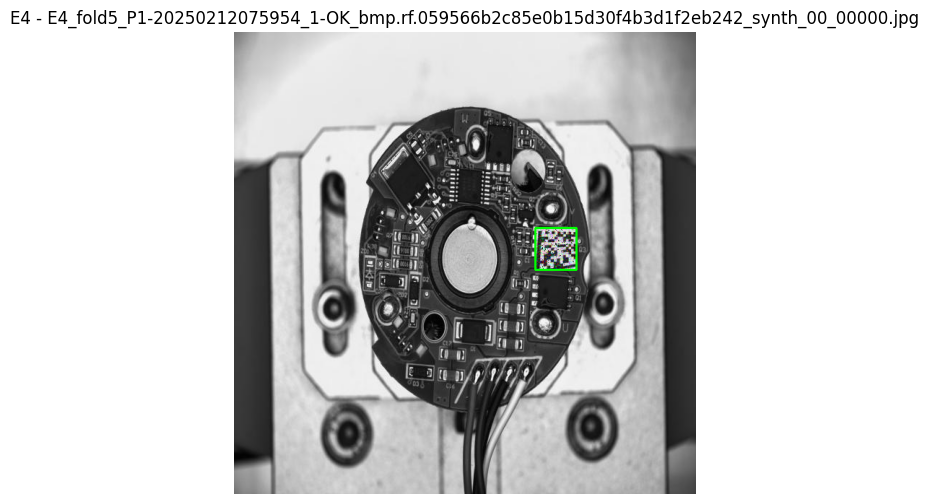

[VISU E4] E4_fold5_P1-20250212075954_1-OK_bmp.rf.059566b2c85e0b15d30f4b3d1f2eb242_synth_00_00000.jpg
0 0.696094 0.469531 0.089063 0.089063
--------------------------



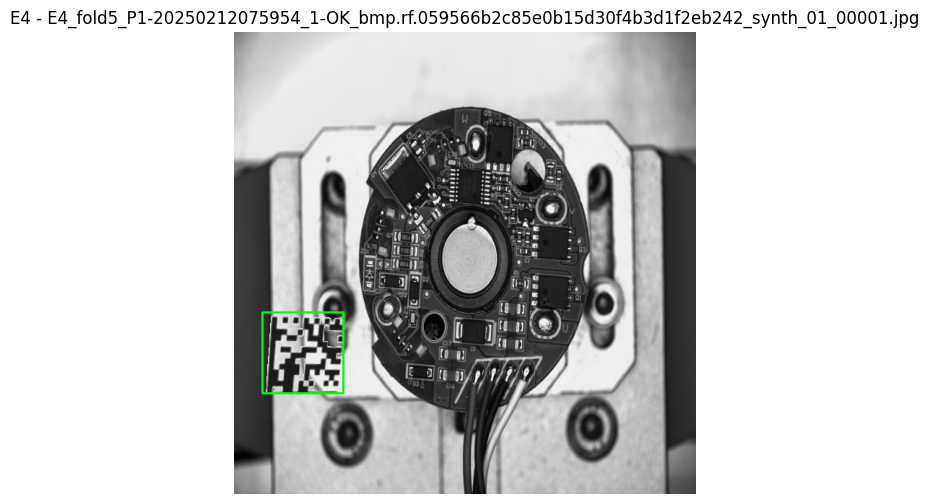

[VISU E4] E4_fold5_P1-20250212075954_1-OK_bmp.rf.059566b2c85e0b15d30f4b3d1f2eb242_synth_01_00001.jpg
0 0.148438 0.693750 0.175000 0.175000
--------------------------



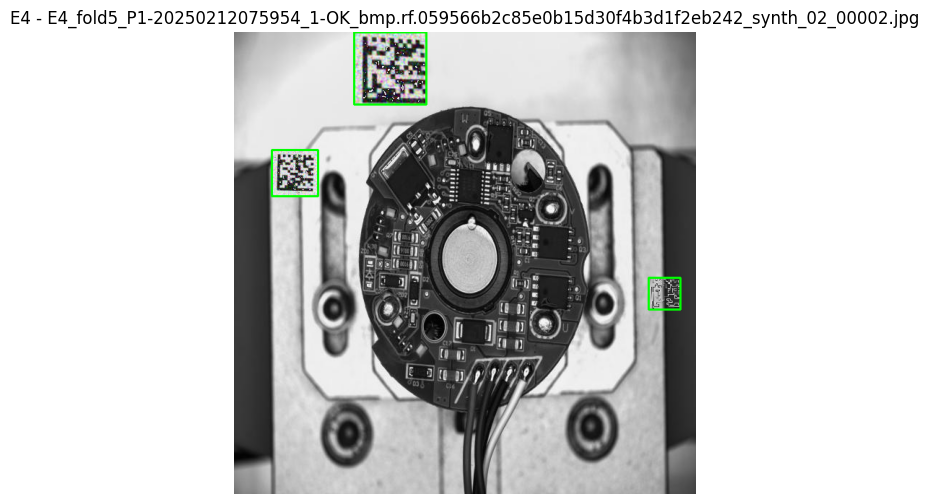

[VISU E4] E4_fold5_P1-20250212075954_1-OK_bmp.rf.059566b2c85e0b15d30f4b3d1f2eb242_synth_02_00002.jpg
0 0.132812 0.304688 0.100000 0.100000
0 0.931250 0.567187 0.068750 0.068750
0 0.338281 0.078906 0.154688 0.154688
--------------------------

[OK] Variant E4 terminé : 4584 images générées (attendu ≈ 4584)


In [ ]:
# %%
from pathlib import Path
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np  # Assure-toi que numpy est importé

# Dossier racine où stocker les variantes
VARIANTS_ROOT = Path("./synthetic_pcb_dm_variantsv2")
VARIANTS_ROOT.mkdir(parents=True, exist_ok=True)

# Relire les backgrounds existants
valid_exts = {".jpg", ".jpeg", ".png", ".bmp"}
background_paths = sorted([p for p in BACKGROUND_DIR.iterdir()
                          if p.suffix.lower() in valid_exts])

N_BACKGROUNDS = len(background_paths)
print(f"{N_BACKGROUNDS} backgrounds trouvés dans {BACKGROUND_DIR}")

if N_BACKGROUNDS == 0:
    raise RuntimeError("Aucun background trouvé, vérifie BACKGROUND_DIR.")

# Cibles en nombre d'images (5%, 10%, 20%, 30% de 18419)
TARGETS = {
    "E5": int(0.05 * 18419),   # 921
    "E10": int(0.10 * 18419),  # 1842
    "E20": int(0.20 * 18419),  # 3684
    "E30": int(0.30 * 18419),  # 5526
}

# Calcul des multiplicateurs par background
variant_multipliers = {}
for name, target in TARGETS.items():
    multiplier = max(1, target // N_BACKGROUNDS)  # Au moins 1 image par background
    variant_multipliers[name] = multiplier
    print(f"Variant {name}: cible {target} images → {multiplier} par background → {multiplier * N_BACKGROUNDS} générées")

random.seed(123)
np.random.seed(123)

# Pour limiter le spam d’images dans le notebook
MAX_VISU_PER_VARIANT = 3

for variant_name, multiplier in variant_multipliers.items():
    print(f"\n========== Génération variant {variant_name} (×{multiplier} par background) ==========")

    variant_img_dir = VARIANTS_ROOT / variant_name / "images"
    variant_lbl_dir = VARIANTS_ROOT / variant_name / "labels"
    variant_img_dir.mkdir(parents=True, exist_ok=True)
    variant_lbl_dir.mkdir(parents=True, exist_ok=True)

    global_counter = 0
    n_visu = 0

    for bg_idx, bg_path in enumerate(background_paths):
        bg = cv2.imread(str(bg_path))
        if bg is None:
            print(f"[WARN] Impossible de lire {bg_path}")
            continue

        h, w = bg.shape[:2]
        bg_name = bg_path.stem

        # On génère `multiplier` images synthétiques à partir de CE background
        for per_bg_idx in range(multiplier):
            img_out = bg.copy()
            labels = []

            occupied_boxes = []  # liste des bboxes déjà placées (en pixels)

            n_dm = random.randint(MIN_DM_PER_IMAGE, MAX_DM_PER_IMAGE)

            for k in range(n_dm):
                text = f"{variant_name}_{per_bg_idx}_{k}"[:10]
                dm = generate_datamatrix(text=text)
                dm_aug = augment_datamatrix(dm)
                dm_resized = resize_dm_for_background(dm_aug, h, w)

                placed = False
                MAX_TRIES = 30

                for _ in range(MAX_TRIES):
                    img_candidate = img_out.copy()
                    img_candidate, bbox = overlay_dm_on_background(img_candidate, dm_resized)

                    if bbox is None:
                        continue

                    # bbox YOLO → pixels
                    xc, yc, w_norm, h_norm = bbox
                    bw = int(w_norm * w)
                    bh = int(h_norm * h)
                    x_center = int(xc * w)
                    y_center = int(yc * h)

                    x1 = x_center - bw // 2
                    y1 = y_center - bh // 2
                    x2 = x_center + bw // 2
                    y2 = y_center + bh // 2

                    new_box = (x1, y1, x2, y2)

                    # Vérifier les collisions
                    collision = any(
                        boxes_intersect(new_box, prev_box, margin_px=10)
                        for prev_box in occupied_boxes
                    )

                    if not collision:
                        # Placement accepté
                        img_out = img_candidate
                        occupied_boxes.append(new_box)
                        labels.append(f"0 {xc:.6f} {yc:.6f} {w_norm:.6f} {h_norm:.6f}")
                        placed = True
                        break

                # Si on n’a pas réussi à placer ce DM → on l’ignore
                if not placed:
                    pass


            if not labels:
                # Aucun DM posé (ça ne devrait quasi jamais arriver)
                continue

            out_name = f"{variant_name}_{bg_name}_synth_{per_bg_idx:02d}_{global_counter:05d}.jpg"
            img_out_path = variant_img_dir / out_name
            label_out_path = variant_lbl_dir / out_name.replace(".jpg", ".txt")

            cv2.imwrite(str(img_out_path), img_out)
            with open(label_out_path, "w") as f:
                f.write("\n".join(labels))

            global_counter += 1

            # Visualisation de quelques exemples dans le notebook
            if n_visu < MAX_VISU_PER_VARIANT:
                vis = img_out.copy()
                for line in labels:
                    cls_id, xc, yc, w_norm, h_norm = line.split()
                    xc, yc, w_norm, h_norm = map(float, (xc, yc, w_norm, h_norm))

                    x_center = xc * w
                    y_center = yc * h
                    bw = w_norm * w
                    bh = h_norm * h

                    x1 = int(x_center - bw / 2)
                    y1 = int(y_center - bh / 2)
                    x2 = int(x_center + bw / 2)
                    y2 = int(y_center + bh / 2)

                    cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

                plt.figure(figsize=(6, 6))
                plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
                plt.title(f"{variant_name} - {out_name}")
                plt.axis("off")
                plt.show()

                print(f"[VISU {variant_name}] {out_name}")
                print("\n".join(labels))
                print("--------------------------\n")
                n_visu += 1

    print(f"[OK] Variant {variant_name} terminé : {global_counter} images générées "
          f"(attendu ≈ {multiplier * N_BACKGROUNDS})")
